# Upscaling Fine Scale Porous Media Grids for Porous Flow Simulation

<table>
<tr>

    
<td><figure>
    <img align="left" src="img/StreamlineF.png" width="300"/>
    <figcaption>Fine scale streamlines and permeability in X direction</figcaption>
    </figure>
    </td>
<td><figure>    
    <img align="left" src="img/StreamlineHarm.png" width="300" />
    <figcaption>Coarse scale streamlines and permeability in X direction</figcaption>
    </figure>
    </td>
</tr></table> 
<br>
<table>
    <td><tr>
    <p style="text-align:center;"> <font size="4" color="black"><b>This notebook introduces:</b>
        <ul><li>Corner Point Grids (CPG)</li>
            <li>Single Phase Flow in Porous Media</li>
            <li>Upscaling of Single Phase Porous Flow Porosity and Permeability</li>
        </ul> <b>The workflow allows to:</b></font></p>
       <ol style="line-height:2;"><font size="4" color="navy">
            <li><p style="text-align:left;"><a href='#1.-Create-a-Geomodel-discretized-by-a-GRDECL-Pillar-Grid' style="text-decoration:none"> Create a Geomodel discretized by a GRDECL Pillar Grid</a></p></li>
            <li><p style="text-align:left;"><a href='#2.-Generate-Porosity-and-Permeability-Fields-and-Compute-Single-Phase-Flow' 
                            style="text-decoration:none"> Generate Porosity and Permeability Fields and Compute Single Phase Flow</a></p></li>
            <li><p style="text-align:left;"><a href='#3.-Construct-a-Coarse-Grid' 
                            style="text-decoration:none"> Construct a Coarse Grid</a></p></li>
            <li><p style="text-align:left;"><a href='#4.-Upscale-Permeability' 
                            style="text-decoration:none"> Upscale Permeability</a></p>
           <ul> <font size="3">
           <li><p style="text-align:left;"><a href='#&#149;-Power-Averaging-Methods' 
                            style="text-decoration:none"> Power Averaging Methods</a></p></li>
           <li><p style="text-align:left;"><a href='#&#149;-Flow-Based-Methods'
                            style="text-decoration:none">Flow Based Methods</a></p></li>
               </font></ul></li>
       </font></ol>
        </tr></td>
</table>
_Author: Mustapha Zakari, RING,ENSG Nancy, France [mustapha.zakari@univ-lorraine.fr]_
        
_Conversion to VTK files is made using PYGRDECL (https://github.com/BinWang0213/PyGRDECL)_    

## 1. Create a Geomodel discretized by a GRDECL Pillar Grid

<p><font size="2" color="grey">
  Jupyter notebook Hints: &nbsp &nbsp &nbsp &nbsp To run a selected notebook cell press [SHIFT + ENTER]. &nbsp &nbsp &nbsp &nbsp To toggle its output press [0] </font>
</p>   

<details>
<summary><p><font size="4" color="green"> Click here to Show/Hide Details</font></p></summary>
<table><tr> 
        <td><img align="left"  src="img/corner_point_grid.png" width="350" /> </td>  
        <td><p style="text-align:left;"><font size="3" color="navy">
            <b>Corner Point Grids (CPG):</b><br>
        		CPG are grids made of hexaedra set on vertical Pillars (<font color="red">red lines in left  figure</font>) where:
        		<ul>
           			<li><p style="text-align:left;">Each Pillar corresponds to one node of an inital 2D Planar Grid </p></li>
                    <li><p style="text-align:left;">Hexadedron  [I,J,K] is set on pillars {[I+inc_I,J+inc_J], inc_I,inc_J in {0,1}}</p></li>
               		<li><p style="text-align:left;">The 8 corners of each hexaedra can slide independently on its 4  pillars</p></li>                    
               	</ul>
               <p style="text-align:left;"><b> CPG with sliding allow to introduce faulting and non orthogonal shapes  </b></p></font>
        </p></td>
</tr></table>
<p><font size="4" color="navy"><b>This section provides instructions to Create/Visualize a CPG according to the parameters set in the figure below:</b></font></p>
<br> 
<img align="center" src="img/GRDECL_simplDisturbed3.png" width="1000"/>
<br>
 
<p style="text-align:right;"><a href='#Upscaling-Fine-Scale-Porous-Media-Grids-for-Porous-Flow-Simulation'>Go to the Table of contents</a></p>
</details>

In [60]:
from GRDECL2VTK import *
from utils import *

# 1.1 Set physical dimensions in physDims (m)
physDims=[2000.,1000.,500.]

# 1.2 Set model grid dimensions in gridDims
Nx=30;  Ny=Nx;  Nz=Nx
gridDims=[Nx,Ny,Nz]

# 1.3 Set corner point grid options
opt=buildCPGGrid_opt(\
disturbed=False,\
flat=True,\
fault_drop=physDims[2]*0.5,\
fault_nx=Nx//2)

# 1.4 Create empty GeologyModel - Build CPG
Model=GeologyModel()
Model.buildCPGGrid(physDims,gridDims,opt)

# 1.5 Visualize Geometry and check initial parameters
Model.plot_scalar("PERMX",add_log_scale=True).show()

     Creating Grid:
       Type: CornerPoint Grid
       Grid Dimensions (NX,NY,NZ): (30 x 30 x 30)
       Number Of Grid Cells: 27000
       Created: Fields: ***PERMX***PERMY***PERMZ***PORO***
[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 216000
     NumOfCells 27000
     .....Done!
[Output] Writing "Results/PILLAR_Grid.vtu" Paraview file....Done!


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## 2. Generate Porosity and Permeability Fields and Compute Single Phase Flow

<details>
    <summary><p><font size="4" color="green"> Click here to Show/Hide Details</font></p></summary>
    <p><font size="4" color="navy">This section provides instructions to:
    <ul><li>Generate/Visualize Basculed Layered-LogNormal permeabilities/porosities histograms and colormaps</li>
        <li>Compute/Visualize pressure colormaps and flow streamlines with a TPFA solver (accurate for K orthogonal CPG)</li> 
    </ul></font>
<table>
    <td><img align="center" src="img/layered_basculed_K50.png" width="500"/></td>
    <td><img align="center" src="img/layered_basculed_PV50.png" width="600"/> </td>
</table>
<p style="text-align:right;"><a href='#Upscaling-Fine-Scale-Porous-Media-Grids-for-Porous-Flow-Simulation'>Go to the Table of contents</a></p>
</details>    

[logNormLayers] Filling K and Phi Z layers with log normal distributions
[logNormLayers] Filling K and Phi Z layers with log normal distributions
[logNormLayers] Done
[UpdateListCellData] varname:PORO
[UpdateListCellData] varname:PERMX
[UpdateListCellData] varname:PERMY
[UpdateListCellData] varname:PERMZ


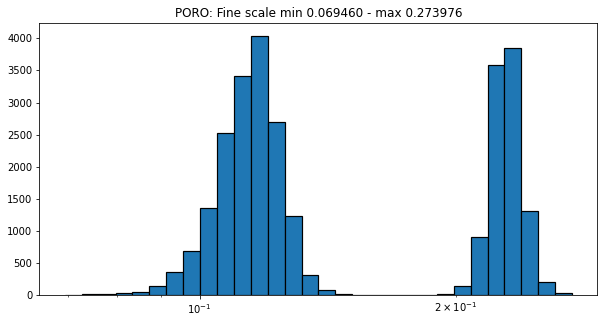

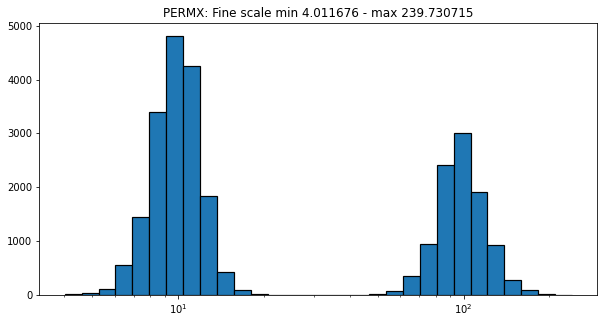

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 216000
     NumOfCells 27000
     .....Done!
[Output] Writing "Results/PILLAR_Grid.vtu" Paraview file....Done!


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [61]:
# 2.1 Create random perm field with normal distribution for each layer
K_LayerPerm=[100,10]*2
K0,phi0=logNormLayers(gridDims,K_LayerPerm,poro_const=0.05)
K,phi=logNormLayers_basc(gridDims,K_LayerPerm,poro_const=0.05)
phi[Model.GRDECL_Data.N//2:]=phi0[Model.GRDECL_Data.N//2:]
K[Model.GRDECL_Data.N//2:]=K0[Model.GRDECL_Data.N//2:]

# 2.2 Update porosity/permeability fields
Update_fields=["PORO","PERMX","PERMY","PERMZ"]
Update_values=[ phi  , K     , K     , 0.1*K ]
Model.UpdateListCellData(var_list=Update_fields,array_list=Update_values)

# 2.3 Visualize Fine scale histogram
for scalar in ["PORO","PERMX"]:
    Model.GRDECL_Data.Plot_hist(scalar,text="Fine scale")

# 2.3 Compute TPFA (block centered) Pressure values
Model.compute_TPFA_Pressure(Press_inj=1,direction="ijk",Fault_opt=opt)
Model.plot_scalar("PERMX",ITK=True).show()
# pl=Model.plot_streamlines(notebook=True, scalar="PERMXLOG10").show()

##  3. Construct a Coarse Grid
<p style="text-align:right;"><a href='#Upscaling-Fine-Scale-Porous-Media-Grids-for-Porous-Flow-Simulation'>Go to the Table of contents</a></p>

[Partioning] Partitoning from Fine grid of size: [40,40,40] to Coarse grid of size: [8,8,8]


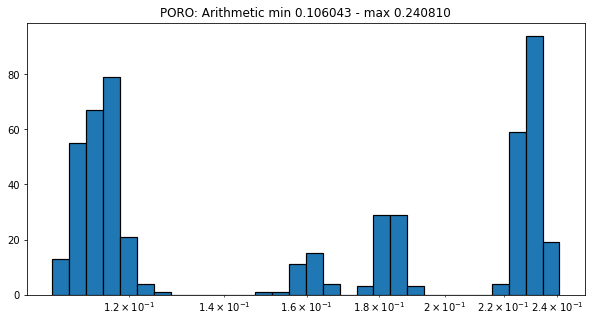

['Arithmetic_mean', 'Geometric_mean', 'Harmonic_mean', 'Harmx_mean', 'Harmy_mean', 'Harmz_mean', 'TPFA_loc', 'TPFA_glob', 'TPFA_loc_vol_average']


In [3]:
# 3.1 Set coarsening factor (grid dimensions of coarse cells)
Model.GRDECL_Data.coarse2fine_ratio=[5]*3

# 3.2 Create coarse grid and upscale porosity
Model2=Model.create_coarse_model()

# List of implemented upscaling methods
methods=Model.Upscaler.list_upscaling_methods()
print(methods)

##  4. Upscale Permeability

### &#149; Power Averaging Methods
<p style="text-align:right;"><a href='#Upscaling-Fine-Scale-Porous-Media-Grids-for-Porous-Flow-Simulation'>Go to the Table of contents</a></p>


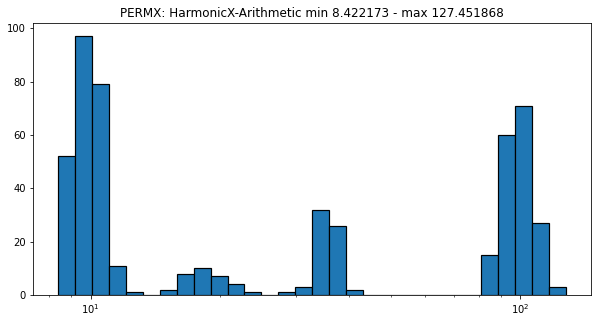

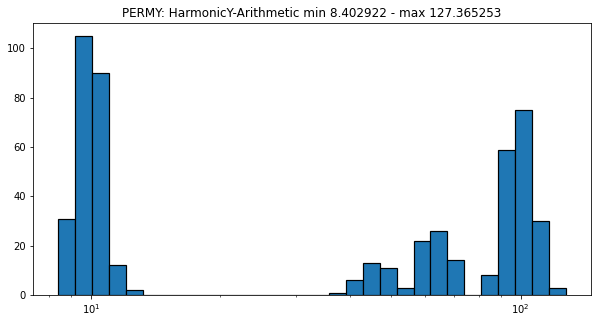

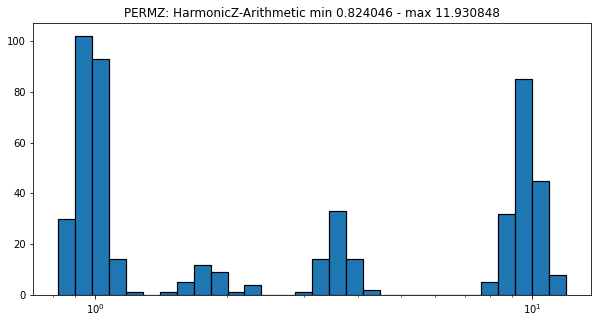

[CreateCellData] Cell variable PERMXLOG10 already existing. Updating it
[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 4096
     NumOfCells 512
     .....Done!
[Output] Writing "Results/PILLAR_Grid_Coarse.vtu" Paraview file....Done!
[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 4096
     NumOfCells 512
     .....Done!
[Output] Writing "Results/PILLAR_Grid_Coarse.vtu" Paraview file....Done!


[(657.1135858404872, -3097.4069252922245, 3149.99998881915),
 (1000.0, 500.0, 375.0),
 (0.10512721849483952, 0.6010978853549453, 0.7922307745558432)]

In [7]:
# 3.3 Upscaling
Model.Upscale_Perm(['Harmx_mean','Harmy_mean','Harmz_mean'])

# 3.3 Compute Pressure for coarse model
Model2.compute_TPFA_Pressure(Press_inj=1,direction="ijk",Fault_opt=opt)
# # Model.two_plots_scalar("Pressure").show(False)
Model2.plot_scalar("PERMX",add_log_scale=True)

Model2.plot_streamlines(notebook=False, scalar="V").show()

In [8]:
# # 3.3 Upscaling
# Model.Upscale_Perm('Harmz_mean')

# # 3.3 Compute Pressure for coarse model
# Model2.compute_TPFA_Pressure(Press_inj=1,direction="i",Fault_opt=opt )
# # # Model.two_plots_scalar("Pressure").show(False)
# Model2.plot_scalar("Pressure").show()



### &#149; Flow Based Methods
<p style="text-align:right;"><a href='#Upscaling-Fine-Scale-Porous-Media-Grids-for-Porous-Flow-Simulation'>Go to the Table of contents</a></p>

[UPSCALING TPFA loc], nlayer: 2


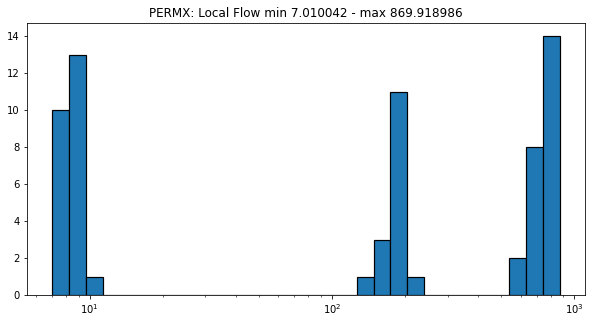

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 64000
     NumOfCells 8000
     .....Done!
[Output] Writing "Results/PILLAR_Grid.vtu" Paraview file....Done!


In [ ]:
# 3.3 Upscaling
Model.Upscaler.nlayer=2
Model.Upscaler.Lin_BC=True
Model.Upscale_Perm('TPFA_loc')

# 3.3 Compute Pressure for coarse model
Model2.compute_TPFA_Pressure(Press_inj=1,direction="ijk",Fault_opt=opt )
# # Model.two_plots_scalar("Pressure").show(False)
# Model2.plot_scalar("Pressure").show()
Model.plot_streamlines(notebook=False).show()

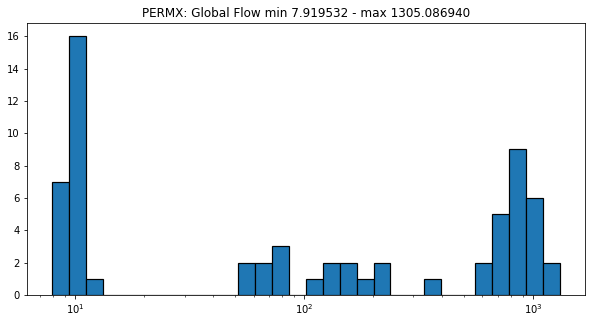

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 64000
     NumOfCells 8000
     .....Done!
[Output] Writing "Results/PILLAR_Grid.vtu" Paraview file....Done!


In [ ]:
# 3.3 Upscaling
Model.Upscaler.nlayer=0
Model.Upscaler.Lin_BC=False
Model.Upscale_Perm('TPFA_glob')

# 3.3 Compute Pressure for coarse model
Model2.compute_TPFA_Pressure(Press_inj=1,direction="ijk",Fault_opt=opt )
# # Model.two_plots_scalar("Pressure").show(False)
# Model2.plot_scalar("Pressure").show()
Model.plot_streamlines(notebook=False).show()

In [59]:
from math import cos, sin
def mat_rot(theta:float)->float:
    # Defines rotation matrix in X,Z plane
    theta *= np.pi/180 #rad
    Mat_Rot=np.zeros((3,3),dtype=float)
    Mat_Rot[1,1] =  1. # No rotation in Y axis

    Mat_Rot[0,0] = Mat_Rot[2,2] = cos(theta)
    Mat_Rot[2,0] = Mat_Rot[0,2] = sin(theta)
    Mat_Rot[0,2] *= -1.
    return np.matrix(Mat_Rot)

def rotate_tensor(M,theta):
    # Transform diagonal tensor in rotated basis to tensor in canonical basis
    # M : Matrix in rotated basis
    # theta : rotation angle    
    P     = mat_rot(theta) # basis change matrix
    P_inv = np.transpose(P)
    return np.matrix(P)*np.matrix(M)*np.matrix(P_inv)

Tensor=np.diag([2,2,1])
print(Tensor)

theta=45
print(rotate_tensor(Tensor,theta))


[[2 0 0]
 [0 2 0]
 [0 0 1]]
[[1.5 0.  0.5]
 [0.  2.  0. ]
 [0.5 0.  1.5]]
